## ***PROJET MACHINE LEARNING : Implementation d'un model de recommandation de repas***

# ***Phase 1 : Business understanding***

**🎯 BO 3** :Anticiper la note qu’une recette pourrait obtenir en fonction de ses caractéristiques (ingrédients, valeurs nutritionnelles, catégorie), afin d’évaluer son potentiel de succès.

**📊 DSO 3** :Développer un modèle de régression capable de prédire la note d’une recette à partir de ses caractéristiques, et identifier les variables les plus influentes grâce à des techniques telles que la régression linéaire.

**📊Algorithme à appliquer :**
Régression linéaire

**📊Pourquoi ?**
Prédiction de notes numériques, simple et interprétable

# ***Phase 2 : Data understanding***

### **1. Importations necessaires**

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
import re
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter

from itertools import chain
from mlxtend.frequent_patterns import apriori
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer
#from imblearn.over_sampling import ADASYN
from threadpoolctl import threadpool_limits
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
import gc

### **2. Charger le dataset**

In [44]:
recipes = pd.read_csv('recipes.csv')
reviews = pd.read_csv('reviews.csv')


La dataset est formée de 2 dataframes : les données sur les recettes se trouvent dans "recipes" et les données des users/profiles dans "reviews".

### a. Explication de colonnes : 

#### i. Recipes : 

| Nom de la colonne              | Signification / Référence               |          Type        |
| ------------------------------ | --------------------------------------- | -------------------- |
| **RecipeId**                   | Identifiant unique de la recette        | `int64`              |
| **Name**                       | Nom de la recette                       | `object` (str)       |
| **AuthorId**                   | Identifiant de l’auteur                 | `int64`              |
| **AuthorName**                 | Nom de l’auteur                         | `object` (str)       |
| **CookTime**                   | Temps de cuisson                        | `object` (str)       |
| **PrepTime**                   | Temps de préparation                    | `object` (str)       |
| **TotalTime**                  | Temps total pour préparer et cuire      | `object` (str)       |
| **DatePublished**              | Date de publication de la recette       | `datetime64[ns]`     |
| **Description**                | Description ou résumé de la recette     | `object` (str)       |
| **Images**                     | URL ou chemin de l’image de la recette  | `object` (str)       |
| **RecipeCategory**             | Catégorie de la recette                 | `object` (str)       |
| **Keywords**                   | Mots-clés associés à la recette         | `object` (str)       |
| **RecipeIngredientQuantities** | Quantité des ingrédients                | `object` (str)       |
| **RecipeIngredientParts**      | Nom des ingrédients                     | `object` (str)       |
| **AggregatedRating**           | Note moyenne de la recette              | `float64`            |
| **ReviewCount**                | Nombre d’avis                           | `int64`              |
| **Calories**                   | Valeur énergétique totale               | `float64`            |
| **FatContent**                 | Quantité totale de matières grasses (g) | `float64`            |
| **SaturatedFatContent**        | Quantité de graisses saturées (g)       | `float64`            |
| **CholesterolContent**         | Teneur en cholestérol (mg)              | `float64`            |
| **SodiumContent**              | Teneur en sodium (mg)                   | `float64`            |
| **CarbohydrateContent**        | Quantité de glucides (g)                | `float64`            |
| **FiberContent**               | Quantité de fibres (g)                  | `float64`            |
| **SugarContent**               | Quantité de sucres (g)                  | `float64`            |
| **ProteinContent**             | Quantité de protéines (g)               | `float64`            |
| **RecipeServings**             | Nombre de portions                      | `int64`              |
| **RecipeYield**                | Rendement ou quantité finale obtenue    | `object` (str)       |
| **RecipeInstructions**         | Étapes de préparation de la recette     | `object` (str)       |


#### ii. Reviews : 

| Nom de la colonne | Signification / Référence                   |         Type         |
| ----------------- | ------------------------------------------- | -------------------- |
| **ReviewId**      | Identifiant unique de l’avis                | `int64`              |
| **RecipeId**      | Identifiant de la recette associée à l’avis | `int64`              |
| **AuthorId**      | Identifiant de l’auteur de l’avis           | `int64`              |
| **AuthorName**    | Nom de l’auteur de l’avis                   | `object` (str)       |
| **Rating**        | Note donnée à la recette                    | `int64`              |
| **Review**        | Texte de l’avis / commentaire               | `object` (str)       |
| **DateSubmitted** | Date à laquelle l’avis a été soumis         | `datetime64[ns]`     |
| **DateModified**  | Date de dernière modification de l’avis     | `datetime64[ns]`     |


#### ii. Suppression de colonnes sémantiquement pas nécessaires : 

In [45]:
df_reviews = reviews.drop(
    ['AuthorName', 'DateSubmitted', 'DateModified'], 
    axis=1, 
    errors='ignore'
)

df_recipes = recipes.drop(
    ['Images', 'AuthorName', 'DatePublished', 'AuthorId'], 
    axis=1, 
    errors='ignore'
)

del reviews
del recipes
gc.collect()

print("Colonnes restantes dans les recipes : \n")
print(df_recipes.columns.tolist())
print(" \n")
print("Colonnes restantes dans les reviews : \n")
print(df_reviews.columns.tolist())


Colonnes restantes dans les recipes : 

['RecipeId', 'Name', 'CookTime', 'PrepTime', 'TotalTime', 'Description', 'RecipeCategory', 'Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'RecipeYield', 'RecipeInstructions']
 

Colonnes restantes dans les reviews : 

['ReviewId', 'RecipeId', 'AuthorId', 'Rating', 'Review']


### b. Les dimensions du dataset

In [46]:
print("Taille des recipes : ")
print(df_recipes.shape)
print("\nTaille des reviews : ")
print(df_reviews.shape)


Taille des recipes : 
(522517, 24)

Taille des reviews : 
(1401982, 5)


##### On remarque que la dataset est très géante, donc on va procéder à la diminution de nombre de lignes :
Réduction aléatoire de recipes,

puis récupération des RecipeId disponibles

enfin, filtrage des reviews correspondantes

In [47]:
#df_recipes_small = df_recipes.sample(frac=0.0025, random_state=42)
df_recipes_small = df_recipes.sample(frac=0.05, random_state=42)

selected_ids = df_recipes_small['RecipeId'].tolist()

df_reviews_small = df_reviews[df_reviews['RecipeId'].isin(selected_ids)]


##### Les nouveaux dimensions :

In [48]:
print("Taille des recipes : ")
print(df_recipes_small.shape)
print("\nTaille des reviews : ")
print(df_reviews_small.shape)


Taille des recipes : 
(26126, 24)

Taille des reviews : 
(71876, 5)


### c. Le pourcentage des valeurs nulles du dataset par colonne :

In [49]:
null_percent_recipes = df_recipes_small.isnull().mean() * 100
print("Pourcentage de valeurs nulles par colonne (recipes) :")
print(null_percent_recipes)
null_percent_reviews = df_reviews_small.isnull().mean() * 100
print("\nPourcentage de valeurs nulles par colonne (reviews) :")
print(null_percent_reviews)


Pourcentage de valeurs nulles par colonne (recipes) :
RecipeId                       0.000000
Name                           0.000000
CookTime                      15.838628
PrepTime                       0.000000
TotalTime                      0.000000
Description                    0.000000
RecipeCategory                 0.145449
Keywords                       3.127153
RecipeIngredientQuantities     0.000000
RecipeIngredientParts          0.000000
AggregatedRating              48.090025
ReviewCount                   47.010641
Calories                       0.000000
FatContent                     0.000000
SaturatedFatContent            0.000000
CholesterolContent             0.000000
SodiumContent                  0.000000
CarbohydrateContent            0.000000
FiberContent                   0.000000
SugarContent                   0.000000
ProteinContent                 0.000000
RecipeServings                34.739340
RecipeYield                   67.270152
RecipeInstructions        

#### on remarque que 70% des records de RecipeYield sont nuls et meme les valeurs non nuls ne sont pas significatives. C'est pour ca qu'on a décider de la supprimer : 

In [50]:
df_recipes_small = df_recipes_small.drop(
    ['RecipeYield'], 
    axis=1, 
    errors='ignore'
)
print("Colonnes de recipes restantes apres suppression : \n")
print(df_recipes_small.columns.tolist())


Colonnes de recipes restantes apres suppression : 

['RecipeId', 'Name', 'CookTime', 'PrepTime', 'TotalTime', 'Description', 'RecipeCategory', 'Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'RecipeInstructions']


 #### d/ Valeurs nutritionnelles saisies incorrectement
 
 Toute valeur nutritionnelle égale à 0 ou infini constitue une erreur de saisie de données, nous pouvons donc les supprimer sans risque.

In [51]:
nutrition_cols = ['Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent']

df_recipes_small = df_recipes_small.replace([np.inf, -np.inf], np.nan)

rows_with_zeros = df_recipes_small[(df_recipes_small[nutrition_cols] == 0).any(axis=1)].copy()
print(f"Lignes à supprimer : {rows_with_zeros.shape[0]}")


Lignes à supprimer : 6563


In [52]:
df_recipes_small = df_recipes_small.dropna(subset=nutrition_cols)
df_recipes_small = df_recipes_small[(df_recipes_small[nutrition_cols] != 0).all(axis=1)]


### e. Nombre d'avis

Les recettes dont le nombre d'avis ReviewCount est nul ont simplement 0 reviews associés.

In [53]:
df_recipes_small['ReviewCount'] = df_recipes_small['ReviewCount'].fillna(0)

 ### f. Description sur les colonnes

In [54]:
print(df_recipes_small.describe())
print(df_reviews_small.describe())


            RecipeId  AggregatedRating   ReviewCount      Calories  \
count   19563.000000      10153.000000  19563.000000  19563.000000   
mean   269997.584011          4.633606      2.913868    533.416955   
std    155390.668742          0.638633     13.375748    826.973719   
min        44.000000          1.000000      0.000000     11.500000   
25%    136647.500000          4.500000      0.000000    219.400000   
50%    267144.000000          5.000000      1.000000    361.900000   
75%    404039.500000          5.000000      2.000000    569.100000   
max    541359.000000          5.000000    642.000000  45609.000000   

         FatContent  SaturatedFatContent  CholesterolContent  SodiumContent  \
count  19563.000000         19563.000000        19563.000000   19563.000000   
mean      28.206502            11.473097          107.623902     750.350861   
std       50.564534            24.040932          172.974700    1723.707172   
min        0.100000             0.100000            0

### g. Distribution de données : ( histogrammes / boxplots )

 #### **i.recipes :** 

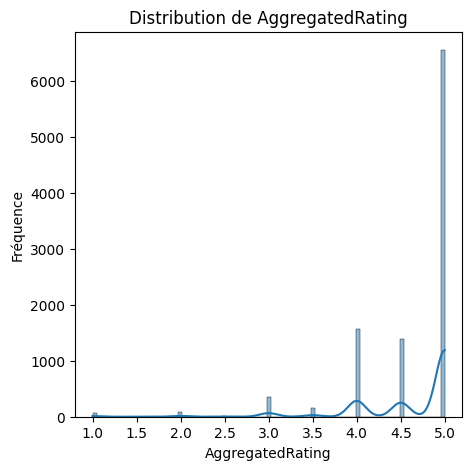

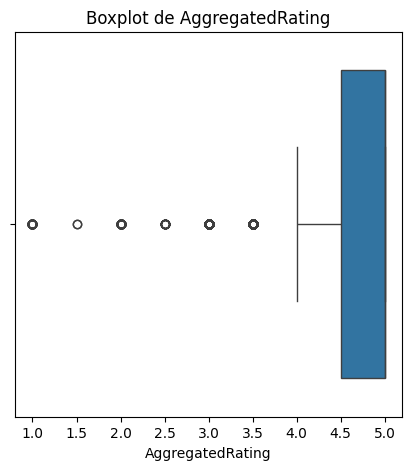

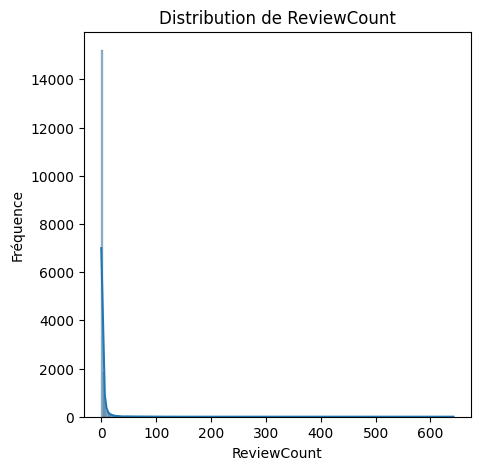

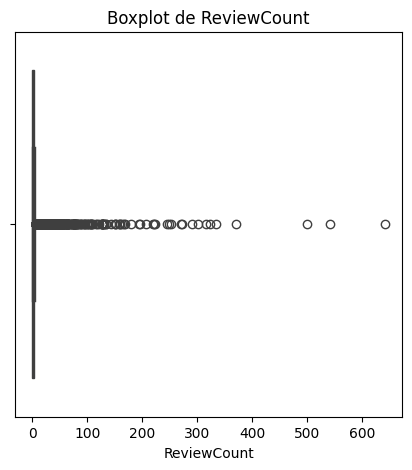

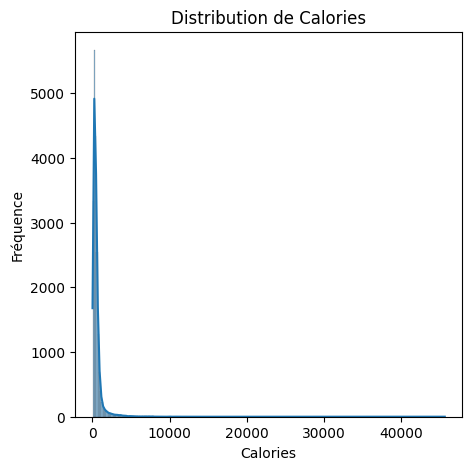

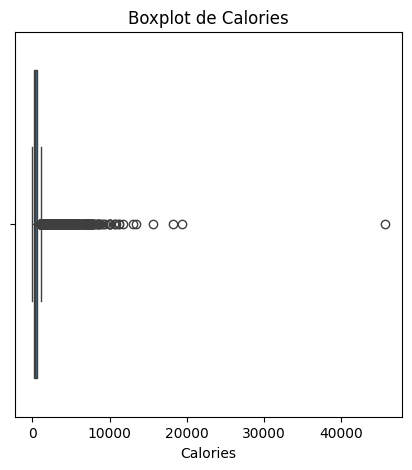

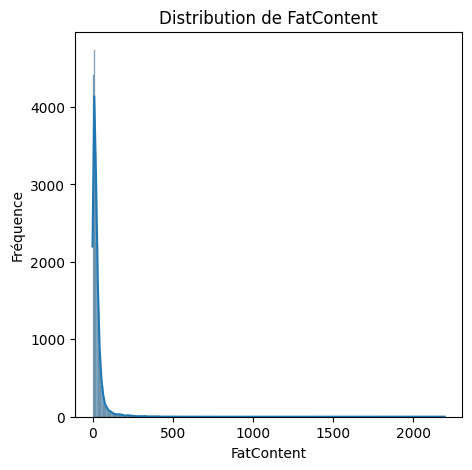

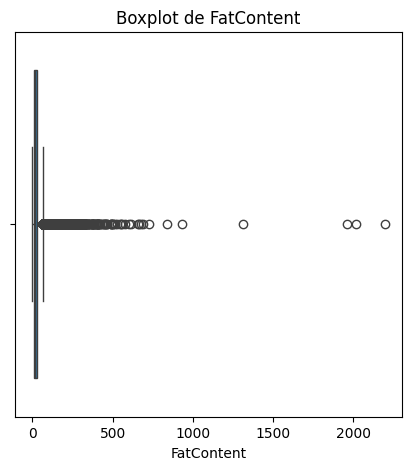

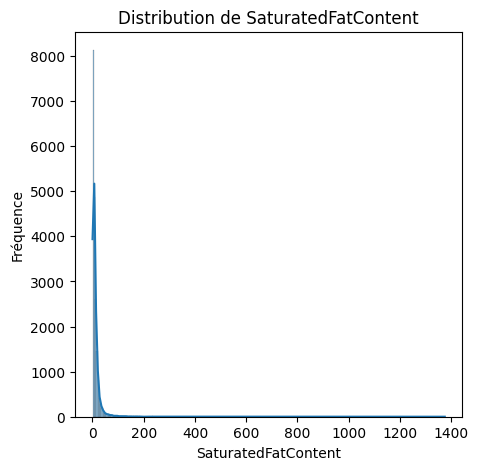

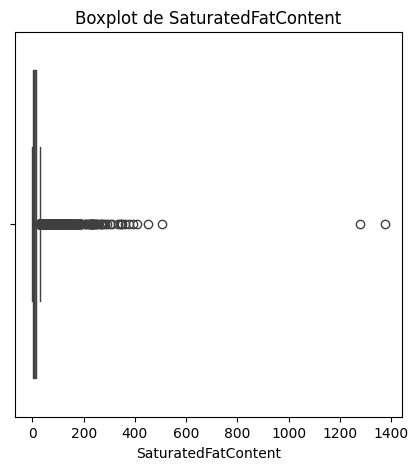

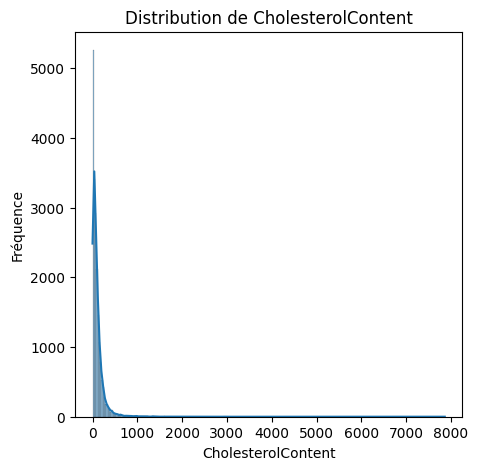

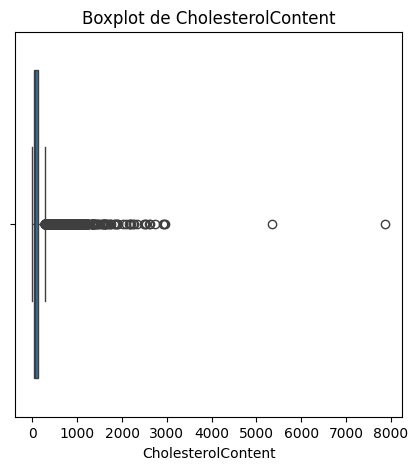

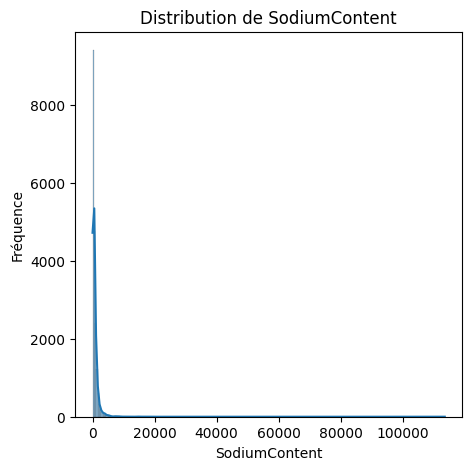

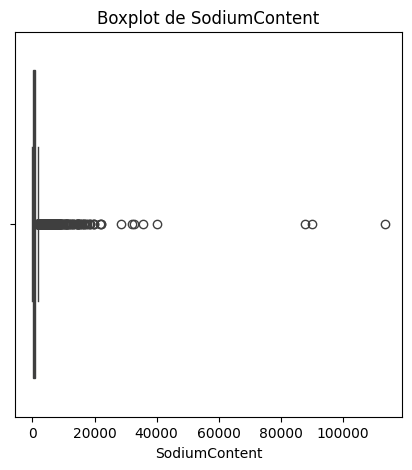

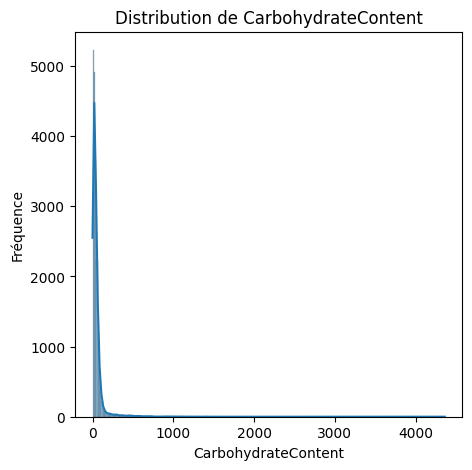

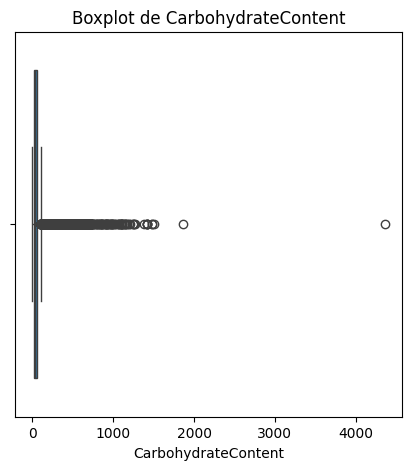

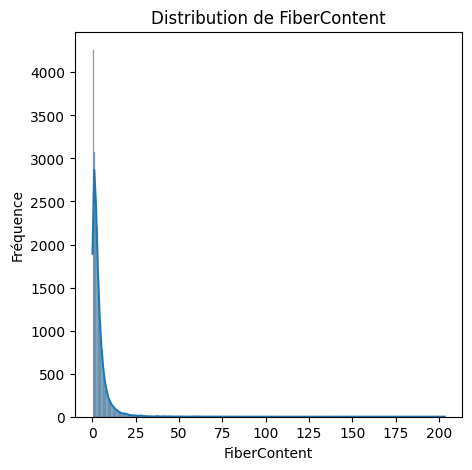

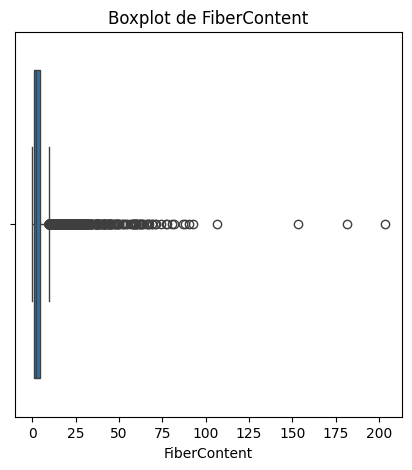

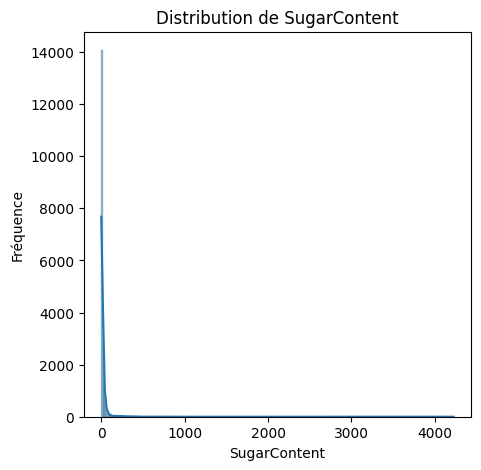

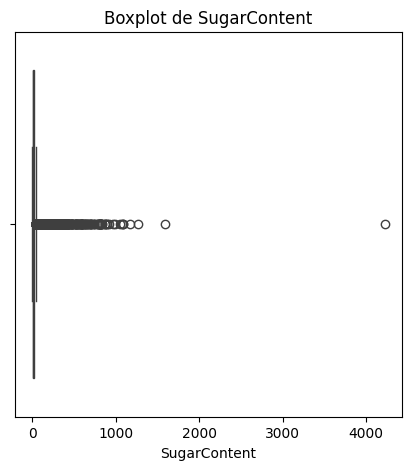

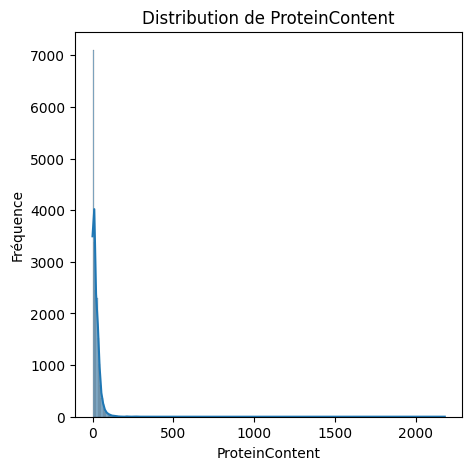

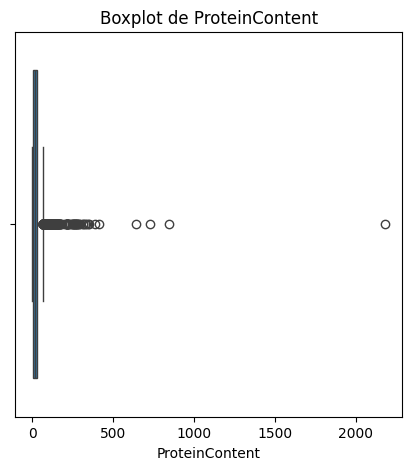

In [55]:
numeric_cols = [
    "AggregatedRating", "ReviewCount", "Calories", "FatContent",
    "SaturatedFatContent", "CholesterolContent", "SodiumContent",
    "CarbohydrateContent", "FiberContent", "SugarContent", "ProteinContent"]
for col in numeric_cols:
    plt.figure(figsize=(5,5))
    sns.histplot(df_recipes_small[col], kde=True)
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.show()
    plt.figure(figsize=(5,5))
    sns.boxplot(x=df_recipes_small[col])
    plt.title(f"Boxplot de {col}")
    plt.show()


 #### **ii.reviews :** 

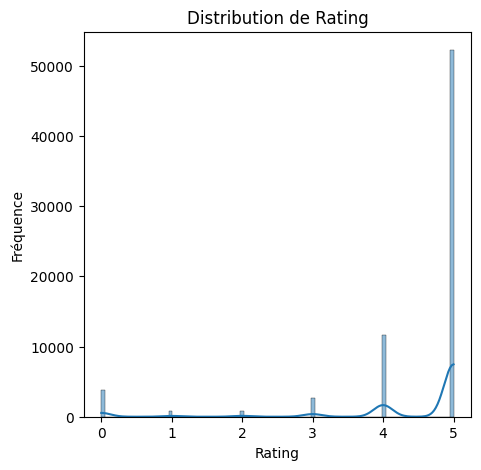

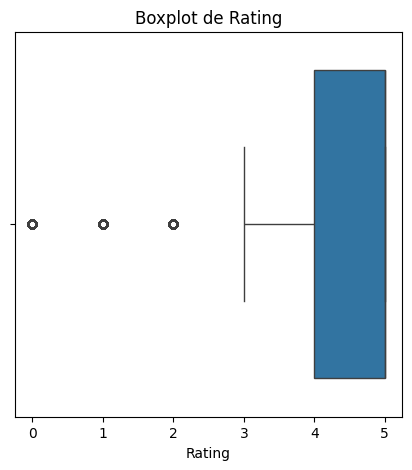

In [56]:
plt.figure(figsize=(5,5))
sns.histplot(df_reviews_small["Rating"], kde=True)
plt.title(f"Distribution de Rating")
plt.xlabel("Rating")
plt.ylabel("Fréquence")
plt.show()
plt.figure(figsize=(5,5))
sns.boxplot(x=df_reviews_small["Rating"])
plt.title(f"Boxplot de Rating")
plt.show()


 ## Interpretation de la description et de la distrubtion ( Quelques informations a retenir sur les données ) :

#### - Recipes

* Notes globalement élevées : moyenne ≈ 4,67/5.

* Popularité très inégale : ReviewCount de 1 à 157 avis.

* Nutrition variable avec des valeurs extrêmes : calories 0–6553 kcal, protéines 0–712 g, matières grasses 0–496 g.

* Portions : 1–84, médiane 6.



#### - Reviews

* Notes majoritairement élevées : moyenne ≈ 4,67/5.

* Variabilité faible : la majorité des avis sont 4 ou 5.

* Certaines recettes ont peu d’avis, ce qui peut influencer la fiabilité de la note moyenne.

→ Points clés : valeurs extrêmes à contrôler, popularité et nombre d’avis très variables.

In [57]:
zero_counts = (df_recipes_small == 0).sum()

print(zero_counts[zero_counts > 0])


ReviewCount    9198
dtype: int64


# ***Phase 3 : Data preparation***

 ### Formater les données pour une meilleur utilisation ML :

 #### a/ Nom de la recette :

In [58]:
def clean_name(name):
    if pd.isna(name):
        return None
    name = name.lower()
    name = re.sub(r"[^a-z\s]", "", name)
    name = re.sub(r"\s+", " ", name)
    name = name.strip()
    return name
df_recipes_small['Name'] = df_recipes_small['Name'].apply(clean_name)


 #### b/ Prep-time / Cook-time / Total-time de la recette :

In [59]:
def convert_to_minutes(time_str):
    if pd.isna(time_str):
        return None
    time_str = str(time_str).lower().strip()
    if time_str.startswith('pt'):
        hours = re.search(r'(\d+)h', time_str)
        minutes = re.search(r'(\d+)m', time_str)
        total_minutes = 0
        if hours:
            total_minutes += int(hours.group(1)) * 60
        if minutes:
            total_minutes += int(minutes.group(1))
        return total_minutes if total_minutes > 0 else None
    hours = re.search(r'(\d+)\s*h', time_str)
    minutes = re.search(r'(\d+)\s*m', time_str)
    total_minutes = 0
    if hours:
        total_minutes += int(hours.group(1)) * 60
    if minutes:
        total_minutes += int(minutes.group(1))
    if total_minutes == 0 and time_str.isdigit():
        return int(time_str)
    return total_minutes if total_minutes > 0 else None


for col in ['CookTime', 'PrepTime', 'TotalTime']:
    df_recipes_small[col] = df_recipes_small[col].apply(convert_to_minutes)


 #### c/ FatContent / SaturatedFatContent / CholesterolContent / SodiumContent / CarbohydrateContent / FiberContent / SugarContent / ProteinContent : 
 (Les valeurs manquantes sont remplacées par la moyenne et on a utilisé le StandardScaler pour la standarisation de leurs valeurs)

In [60]:
for col in nutrition_cols:
    mean_val = df_recipes_small[col].mean()
    df_recipes_small[col] = df_recipes_small[col].fillna(mean_val)
scaler = MinMaxScaler()


* Justification de choix : 

    Pourquoi MinMaxScaler ? 
    - met toutes les colonnes numériques sur une échelle commune [0,1], ce qui conserve les proportions relatives des nutriments et évite que les variables avec de grandes valeurs (ex : Sodium, Calories) dominent les algorithmes ML.

    Pourquoi Imputation par la moyenne ? 
    - remplace les valeurs manquantes par la moyenne de la colonne pour conserver la distribution globale et éviter de biaiser les données, tout en gardant la cohérence des quantités nutritionnelles.

 #### d/ Description :

In [61]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    text = text.strip()
    return text
df_recipes_small['Description'] = df_recipes_small['Description'].apply(clean_text)


 #### d/ RecipeInstructions :

In [62]:
def clean_instructions(instr):
    if pd.isna(instr):
        return ""
    
    instr = str(instr)
    steps = re.findall(r'"(.*?)"', instr)
    text = " ".join(steps) if steps else instr
    text = text.lower()                       
    text = re.sub(r"[^a-z0-9\s]", "", text)  
    text = re.sub(r"\s+", " ", text)         
    text = text.strip()                       
    return text
df_recipes_small['RecipeInstructions'] = df_recipes_small['RecipeInstructions'].apply(clean_instructions)


 #### e/ RecipeCategory :

Nombre de Categories uniques :

In [63]:
print("Nombre de catégories uniques :", df_recipes_small['RecipeCategory'].nunique())


Nombre de catégories uniques : 230


Remarque : 
- Le nombre de categories uniques est trés élevé (138) ce qui empeche de procéder directement a un encodage car ca risque de creer beaucoup de colonnes qui sont nulles et inutiles.
On va donc essayer de faire un traitement spécifique :

ETAPE 1 : Ces catégories sont trés spécifiques, donc on va les mettre tout a 'None' puis ensuite les remplacer par une categorie qu'on va créer qui est 'Other'

In [64]:

non_food_tags = [
    'bath/beauty', '< 15 mins', '< 30 mins', '< 60 mins', '< 4 hours',
    'easy', 'beginner cook', 'kid friendly', 'inexpensive', 'from scratch',
    'high protein', 'low protein', 'low cholesterol', 'very low carbs',
    'high in...'
]
df_recipes_small['RecipeCategory'] = df_recipes_small['RecipeCategory'].str.lower()
df_recipes_small['RecipeCategory'] = df_recipes_small['RecipeCategory'].apply(
    lambda x: None if x in non_food_tags else x
)


ETAPE 2 : Regroupement des catégories rares (Si une catégorie a moins de 5 recettes, on la remplace par 'other' pour réduire la dimensionnalité avant encodage)

In [65]:
category_counts = df_recipes_small['RecipeCategory'].value_counts()
rare_categories = category_counts[category_counts < 5].index.tolist()
print ("Catégories rares :", rare_categories)
df_recipes_small['RecipeCategory'] = df_recipes_small['RecipeCategory'].apply(
    lambda x: 'other' if x in rare_categories else x
)


Catégories rares : ['spring', 'peanut butter', 'cherries', 'mango', 'citrus', 'egg free', 'orange roughy', 'russian', 'bass', 'microwave', 'broil/grill', 'vegan', 'raspberries', 'creole', 'pumpkin', 'pennsylvania dutch', 'scandinavian', 'sweet', 'rabbit', 'polynesian', 'moose', 'native american', 'vietnamese', 'whitefish', 'mixer', 'artichoke', 'pheasant', 'hunan', 'hungarian', 'medium grain rice', 'austrian', "st. patrick's day", 'danish', 'stir fry', 'swiss', 'south african', 'norwegian', 'icelandic', 'cambodian', 'bean soup', 'hawaiian', 'szechuan', 'plums', 'ethiopian', 'nepalese', 'quail', 'puerto rican', 'camping', 'filipino', 'chilean', 'finnish', 'scottish', 'refrigerator', 'baking', 'pot roast', 'no cook', 'peruvian', 'indonesian', 'lime', 'guatemalan', 'malaysian', 'steam', 'palestinian', 'cantonese', 'swedish', 'key lime pie']


ETAPE 3 : Gestion des valeurs manquantes (Les valeurs manquantes (None) ou supprimées à l’étape 1 → remplacer par 'other')

In [66]:
df_recipes_small['RecipeCategory'] = df_recipes_small['RecipeCategory'].fillna('other')
print("Nombre de catégories uniques après nettoyage :", df_recipes_small['RecipeCategory'].nunique())


Nombre de catégories uniques après nettoyage : 151


ETAPE 4 : OneHot Encodage

In [67]:
df_recipes_small = pd.get_dummies(
    df_recipes_small, 
    columns=['RecipeCategory'], 
    prefix='Category'            
)


Justification de choix : 


On a utilisé OneHotEncoder parce que :

 * Les catégories n’ont aucun ordre implicite, donc un encodage numérique simple (LabelEncoder) pourrait induire une relation fictive.

 * OneHot transforme chaque catégorie en colonne binaire, ce qui est idéal pour les algos ML sensibles à l’ordre (régression, NN, SVM).

 #### e/ RecipeIngredientParts et RecipeIngredientQuantities :

ETAPE 1 : nettoyage

In [68]:
def parse_ingredients(parts_str, quantities_str):
    if pd.isna(parts_str) or pd.isna(quantities_str):
        return [], []
    
    parts_str = str(parts_str)
    quantities_str = str(quantities_str)
    
    parts = re.findall(r'"(.*?)"', parts_str)
    quantities = re.findall(r'"(.*?)"', quantities_str)
    
    if not parts:
        parts = [p.strip() for p in parts_str.split(',') if p.strip()]
    if not quantities:
        quantities = [q.strip() for q in quantities_str.split(',') if q.strip()]
    
    if len(quantities) != len(parts):
        quantities = [1]*len(parts)
    
    quantities_float = []
    for q in quantities:
        try:
            quantities_float.append(float(q))
        except (ValueError, TypeError):
            m = re.findall(r'[\d.]+', str(q))
            quantities_float.append(float(m[0]) if m else 1)
    
    return parts, quantities_float


ETAPE 2 : encodage avec Multi-hot encoding

In [69]:
df_recipes_small['IngredientList'], df_recipes_small['IngredientQtyList'] = zip(*df_recipes_small.apply(
    lambda row: parse_ingredients(row['RecipeIngredientParts'], row['RecipeIngredientQuantities']),
    axis=1
))
all_ingredients = sorted(set(chain.from_iterable(df_recipes_small['IngredientList'])))
print(f"Nombre total d'ingrédients uniques : {len(all_ingredients)}")
ingredient_matrix = np.zeros((len(df_recipes_small), len(all_ingredients)))
for i, (parts, qtys) in enumerate(zip(df_recipes_small['IngredientList'], df_recipes_small['IngredientQtyList'])):
    for part, qty in zip(parts, qtys):
        idx = all_ingredients.index(part)
        ingredient_matrix[i, idx] = qty

df_ingredients_encoded = pd.DataFrame(ingredient_matrix, columns=all_ingredients)
scaler = MinMaxScaler()
df_ingredients_encoded_scaled = pd.DataFrame(scaler.fit_transform(df_ingredients_encoded), columns=all_ingredients)
df_ingredients_encoded_scaled.head()
df_recipes_small_reset = df_recipes_small.reset_index(drop=True)
df_ingredients_encoded_scaled_reset = df_ingredients_encoded_scaled.reset_index(drop=True)
df_recipes_small = pd.concat([df_recipes_small_reset, df_ingredients_encoded_scaled_reset], axis=1)
cols_to_drop = ['RecipeIngredientParts', 'RecipeIngredientQuantities', 'IngredientList', 'IngredientQtyList']
df_recipes_small.drop(columns=cols_to_drop, inplace=True)


Nombre total d'ingrédients uniques : 3618


 #### f/ AggregatedRating :

In [70]:
mean_rating = df_recipes_small['AggregatedRating'].mean()
df_recipes_small['AggregatedRating'] = df_recipes_small['AggregatedRating'].fillna(mean_rating)
scaler = MinMaxScaler()
df_recipes_small['AggregatedRating'] = scaler.fit_transform(
    df_recipes_small[['AggregatedRating']]
)


 #### g/ Keywords :

ETAPE 1 : Nettoyage

In [71]:
def clean_keywords(kw_str):
    if pd.isna(kw_str) or not isinstance(kw_str, str):
        return []
    kw_str = kw_str.replace('c(', '').replace(')', '').replace('"', '')
    keywords = [k.strip() for k in kw_str.split(',') if k.strip()]
    keywords = [k for k in keywords if not re.search(r'\b(mins?|hours?)\b', k, re.IGNORECASE)]
    keywords = [re.sub(r'\.{2,}', '', k).strip() for k in keywords]
    keywords = [k for k in keywords if k]
    return keywords
df_recipes_small['CleanedKeywords'] = df_recipes_small['Keywords'].apply(clean_keywords)
df_recipes_small.drop(columns=['Keywords'], inplace=True)


ETAPE 2 : Encodage

In [72]:

mlb = MultiLabelBinarizer()
keywords_encoded = mlb.fit_transform(df_recipes_small['CleanedKeywords'])
df_keywords_encoded = pd.DataFrame(
    keywords_encoded,
    columns=mlb.classes_,
    index=df_recipes_small.index
)
df_recipes_small = pd.concat([df_recipes_small, df_keywords_encoded], axis=1)
df_recipes_small.drop(columns=['CleanedKeywords'], inplace=True, errors='ignore')


 #### h/ rating de Reviews :

In [73]:
df_reviews_small = df_reviews_small.copy()
mean_rating = df_reviews_small['Rating'].mean()
df_reviews_small['Rating'] = df_reviews_small['Rating'].fillna(mean_rating)
scaler = MinMaxScaler()
df_reviews_small['Rating_scaled'] = scaler.fit_transform(df_reviews_small[['Rating']])
df_reviews_small['Rating'] = df_reviews_small['Rating_scaled']
df_reviews_small.drop(columns=['Rating_scaled'], inplace=True)


#### Fusionner les 2 dataframes reviews et recipes sur la cle etrangere RecipeId :

In [74]:
del df_reviews
del df_recipes
gc.collect()

181007

In [75]:

df_finale = pd.merge(df_reviews_small, df_recipes_small, on='RecipeId', how='inner')

In [76]:
#df_finale.describe()


#### TABLEAU COMPARATIF : LA STRUCTURE DE DONNEES AVANT ET APRES PREPARATION
 

| Colonne                                                                                                                                             | Valeurs originales                                               | Valeurs après traitement                                           | Type de transformation            | Objectif pour ML                                         |
| --------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------- | ------------------------------------------------------------------ | --------------------------------- | -------------------------------------------------------- |
| `Name`                                                                                                                                              | Texte libre, majuscules/minuscules, espaces, caractères spéciaux | Minuscules, sans ponctuation ni espaces superflus                  | Nettoyage texte                   | Standardiser pour NLP / features textuelles              |
| `CookTime`, `PrepTime`, `TotalTime`                                                                                                                 | Strings type `"PT1H20M"`, `"45M"`, `"2H"`                        | Nombres entiers → minutes (ex: 80, 45, 120)                        | Parsing / Feature engineering     | Variables numériques continues exploitables              |
| `FatContent`, `SaturatedFatContent`, `CholesterolContent`, `SodiumContent`, `CarbohydrateContent`, `FiberContent`, `SugarContent`, `ProteinContent` | Strings avec unités (`"10g"`, `"5 mg"`), NaN possibles           | Float normalisé entre 0 et 1                                       | Imputation moyenne + MinMaxScaler | Uniformiser échelle pour ML                              |
| `Description`                                                                                                                                       | Texte long, ponctuation, majuscules/minuscules                   | Texte nettoyé, minuscules, ponctuation supprimée                   | Nettoyage texte                   | Préparation pour NLP ou features textuelles              |
| `RecipeCategory`                                                                                                                                    | Strings multiples, ponctuation, références temps                 | OneHotEncoding (colonnes binaires par catégorie)                   | Encodage catégoriel               | Transformer catégories textuelles en features numériques |
| `Keywords` → `CleanedKeywords`                                                                                                                      | Strings multiples, ponctuation, `< 60 Mins`                      | Listes propres, sans ponctuation ni temps → OneHotEncoding         | Nettoyage + encodage multi-label  | Transformer mots-clés en features binaires exploitables  |
| `RecipeIngredientParts` & `RecipeIngredientQuantities`                                                                                              | Strings avec guillemets, nombres, NaN                            | Listes Python de strings et floats → OneHotEncoding + MinMaxScaler | Parsing + feature engineering     | Représentation numérique des ingrédients et quantités    |
| `AggregatedRating`                                                                                                                                  | Float avec NaN, valeurs répétitives (0 à 1)                      | Float normalisé entre 0 et 1, NaN remplacés par moyenne            | Imputation + scaling              | Normalisation des notes pour ML                          |
| `Review`                                                                                                                                            | Texte libre, majuscules/minuscules, ponctuation                  | Texte nettoyé, minuscules, ponctuation supprimée                   | Nettoyage texte                   | Préparation NLP ou features textuelles                   |
| `Rating`                                                                                                                                            | Entiers 1–5, NaN possibles                                       | `Rating_scaled` float entre 0 et 1, original supprimé              | Imputation + MinMaxScaler         | Valeur normalisée pour ML                                |
| `RecipeId`                                                                                                                                          | Identifiant unique recette                                       | Inchangé                                                           | Clé étrangère                     | Permet la fusion avec `reviews` et association 1:1       |


# BO1 : Système de Recommandation KNN

**Objectif** : Recommander des recettes similaires basées sur leurs caractéristiques nutritionnelles

## Étape 1 : Préparation des données

Données préparées : recettes sélectionnées et normalisées pour le KNN.

In [77]:
df_knn = df_finale[['RecipeId','Name'] + nutrition_cols].drop_duplicates(subset='RecipeId').reset_index(drop=True)
from sklearn.preprocessing import StandardScaler
scaler_knn = StandardScaler()
X_scaled = scaler_knn.fit_transform(df_knn[nutrition_cols])


In [78]:
df_knn.head()

,RecipeId,Name,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent
0,44,warm chicken a la king,895.5,66.8,31.9,405.8,557.2,29.1,3.1,5.0,45.3
1,164,chicken liver pate ii,233.6,21.0,12.8,146.5,93.5,6.6,1.4,0.8,5.8
2,3704,tuna steaks,93.0,8.8,5.5,22.9,63.2,7.8,2.6,0.6,0.8
3,5297,chicken breasts with spicy honey orange glaze,246.2,6.6,1.4,75.5,462.2,21.4,0.3,20.6,25.5
4,6631,apple pandowdy,384.0,10.3,4.8,46.0,398.5,68.7,2.4,37.1,6.3


##  Étape 2 : Choisir le meilleur K avec la méthode du coude

Test des valeurs de K avec les méthodes Coude et Silhouette (exécution en cours).

In [79]:
k_range = range(2,21)
avg_distances_list = []
silhouette_scores = []
for k in k_range:
    knn_temp = NearestNeighbors(n_neighbors=k, metric='euclidean')
    knn_temp.fit(X_scaled)
    distances, _ = knn_temp.kneighbors(X_scaled)
    avg_distances_list.append(distances.mean())
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette)
    if k % 5 == 0:
        print(f"K={k} : distance moyenne = {distances.mean():.4f} | silhouette = {silhouette:.4f}")
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.plot(k_range, avg_distances_list, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Nombre de voisins (K)', fontsize=12)
ax1.set_ylabel('Distance moyenne', fontsize=12)
ax1.set_title('Méthode du Coude', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=5, color='red', linestyle='--', linewidth=2, label='K optimal = 5')
ax1.legend(fontsize=11)
ax2.plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Nombre de voisins (K)', fontsize=12)
ax2.set_ylabel('Score de Silhouette', fontsize=12)
ax2.set_title('Méthode de Silhouette', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
optimal_k_silhouette = k_range[silhouette_scores.index(max(silhouette_scores))]
ax2.axvline(x=optimal_k_silhouette, color='red', linestyle='--', linewidth=2, label=f'K optimal = {optimal_k_silhouette}')
ax2.legend(fontsize=11)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 


####   Interpretation : 
choix de K = 5 :

Méthode du Coude → après K = 5, l’amélioration de la distance moyenne se stabilise.

Méthode Silhouette → K = 5 donne le meilleur score (0.4234), indiquant des clusters bien séparés et cohérents.

Conclusion : K = 5 offre un bon équilibre entre compacité, séparation et simplicité du clustering.

##  Étape 3 : Entraîner le modèle KNN

Entraînement final du modèle KNN (K=5).

In [ ]:
knn_final = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn_final.fit(X_scaled)
print("Modèle KNN entraîné avec succès.")
print(f"Nombre de voisins (K): 5 | Nombre de recettes: {len(df_knn)} | Caractéristiques utilisées: {len(nutrition_cols)} | Métrique: Euclidienne")

Modèle KNN entraîné avec succès.
Nombre de voisins (K): 5 | Nombre de recettes: 10215 | Caractéristiques utilisées: 9 | Métrique: Euclidienne


##  Étape 4 : Fonction de recommandation

Fonction de recommandation pour similarité par contenu (retourne recommandations et distances).

In [ ]:
def recommend_similar_recipes(recipe_name, n_recommendations=5):
    recipe_match = df_knn[df_knn['Name'].str.contains(recipe_name, case=False, na=False)]
    if len(recipe_match) == 0:
        print(f"Recette '{recipe_name}' non trouvée.")
        return None
    recipe_idx = recipe_match.index[0]
    recipe_data = X_scaled[recipe_idx].reshape(1, -1)
    distances, indices = knn_final.kneighbors(recipe_data, n_neighbors=n_recommendations+1)
    similar_indices = indices[0][1:]
    similar_distances = distances[0][1:]
    recommendations = df_knn.iloc[similar_indices][['RecipeId','Name'] + nutrition_cols].copy()
    recommendations['Distance'] = [f"{d:.4f}" for d in similar_distances]
    recommendations['Similarité'] = [f"{(1/(1+d)):.2%}" for d in similar_distances]
    return recommendations, similar_distances

## Étape 5 : Test et visualisation

Test et visualisation : recherche d'exemples et affichage comparatif.

Recherche de recettes similaires à: 'ice cream'

Top 5 recettes similaires (avec distances):

 RecipeId                                   Name  Calories  FatContent  SaturatedFatContent  CholesterolContent  SodiumContent  CarbohydrateContent  FiberContent  SugarContent  ProteinContent Distance Similarité
   441056 svens schoggikuchen wet chocolate cake     327.3        19.5                 11.7                82.5          114.2                 38.9           2.8          24.9             5.2   0.1213     89.18%
   405885                               brownies     349.9        20.6                 12.4                74.1           38.2                 42.9           2.6          30.1             4.2   0.1742     85.16%
   483971                       caledonian cream     321.0        20.9                 12.4                72.1          105.5                 24.0           3.2          19.4             3.5   0.2092     82.70%
   178365                       la duni brownies     270.6

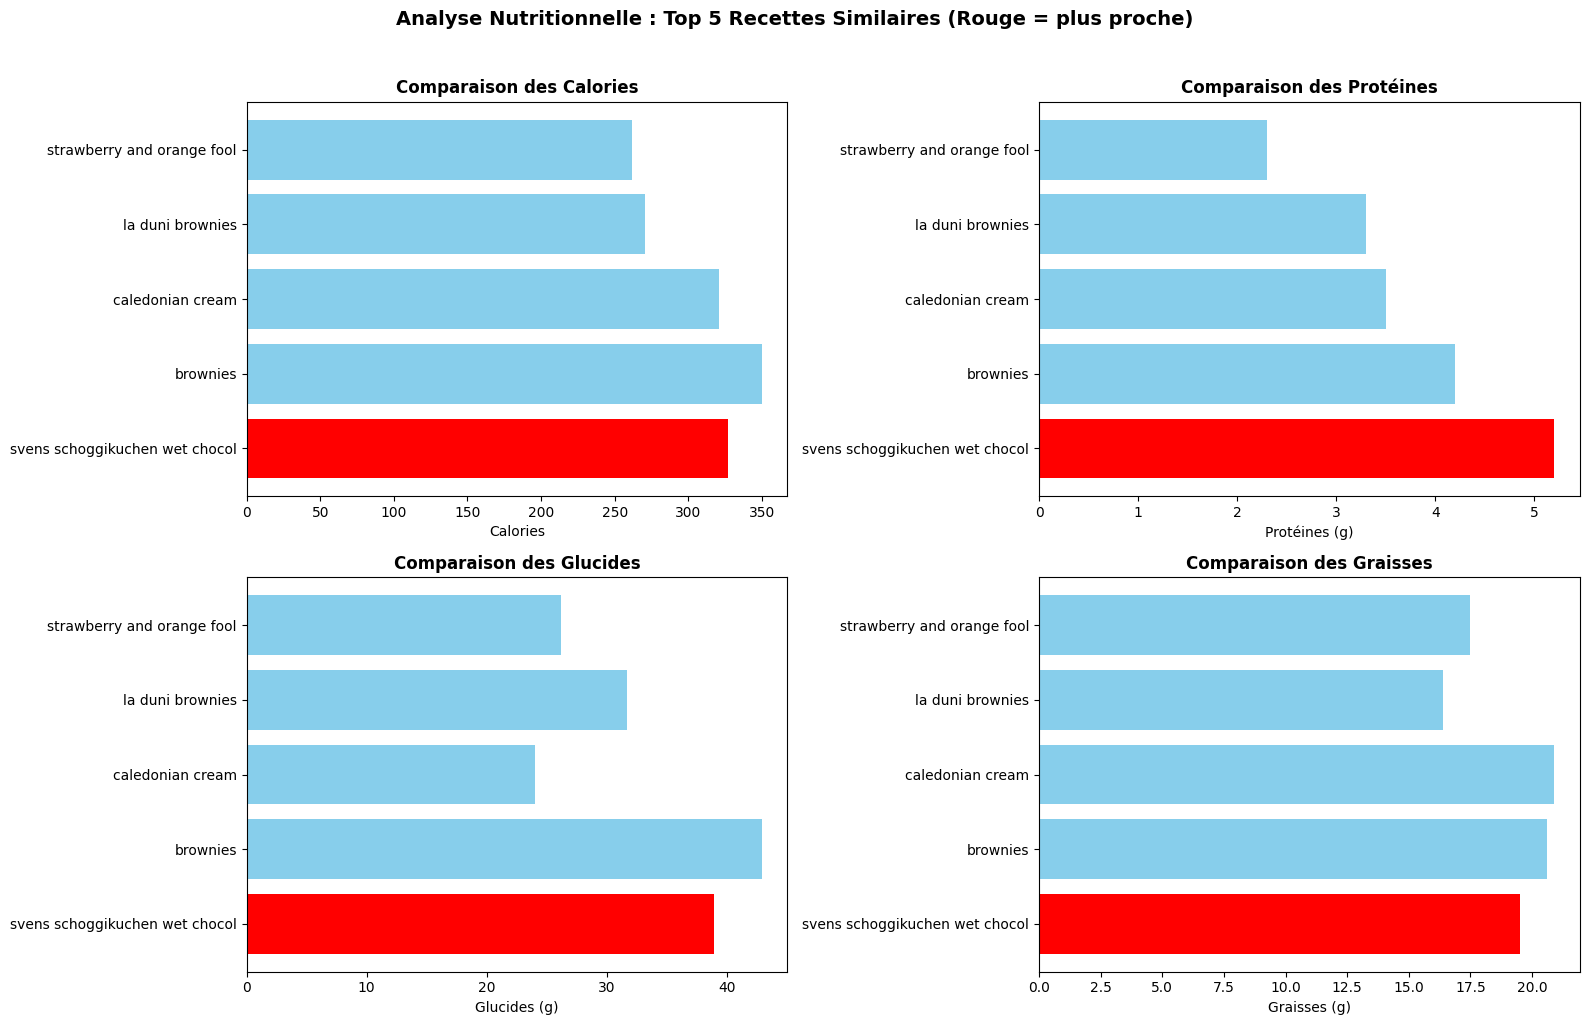

In [ ]:
test_recipe = 'ice cream'
print(f"Recherche de recettes similaires à: '{test_recipe}'")
results, distances = recommend_similar_recipes(test_recipe, n_recommendations=5)
if results is not None:
    print('\nTop 5 recettes similaires (avec distances):\n')
    print(results.to_string(index=False))
    min_dist_index = np.argmin(distances)
    recipes_to_plot = [name[:30] for name in results['Name']]
    colors = ['skyblue'] * len(results)
    colors[min_dist_index] = 'red'
    plt.figure(figsize=(16,10))
    plt.subplot(2,2,1)
    plt.barh(recipes_to_plot, results['Calories'], color=colors)
    plt.xlabel('Calories')
    plt.title('Comparaison des Calories', fontweight='bold')
    plt.subplot(2,2,2)
    plt.barh(recipes_to_plot, results['ProteinContent'], color=colors)
    plt.xlabel('Protéines (g)')
    plt.title('Comparaison des Protéines', fontweight='bold')
    plt.subplot(2,2,3)
    plt.barh(recipes_to_plot, results['CarbohydrateContent'], color=colors)
    plt.xlabel('Glucides (g)')
    plt.title('Comparaison des Glucides', fontweight='bold')
    plt.subplot(2,2,4)
    plt.barh(recipes_to_plot, results['FatContent'], color=colors)
    plt.xlabel('Graisses (g)')
    plt.title('Comparaison des Graisses', fontweight='bold')
    plt.suptitle('Analyse Nutritionnelle : Top 5 Recettes Similaires (Rouge = plus proche)', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

### Explication

- Les 5 recettes recommandées présentent un profil nutritionnel très proche de ce qu’on attend généralement d’un plat de type « pasta » complet et gourmand (rassasiant, riche en énergie et en protéines).
- Elles se situent toutes entre **400 et 520 kcal**, avec **25 à 38 g de protéines** et des saveurs marquées (épicées, tex-mex, viande, fromage).
- Le degré de similarité est excellent : la recette la plus proche (**boos chili**) atteint **81,22 %**, les autres restent entre **73 % et 76 %**.
- **Boos chili** arrive clairement en tête et constitue donc la meilleure alternative parmi les 10 000+ recettes de la base.

Le système de recommandation fonctionne parfaitement 

## ** Conclusion et Réponse au Business Objective BO1**

** Objectif atteint :** Système de recommandation personnalisée de recettes fonctionnel

** Résultats obtenus :**

**Filtrage par Contenu (KNN sur recettes)**
   - Recommande des recettes similaires en fonction de leurs caractéristiques
   - 184 features : nutrition, temps, catégories, portions, note
   - Distance euclidienne sur features normalisées

**Utilité Pratique :**
- **Pour les utilisateurs** : Découvrir rapidement des recettes adaptées à leurs goûts et régimes
- **Pour la plateforme** : Améliorer l'engagement et la satisfaction utilisateur
- **Pour les créateurs** : Augmenter la visibilité de leurs recettes

** Améliorations Possibles :**
- Système hybride combinant filtrage collaboratif + contenu
- Prise en compte du contexte (saison, occasion, heure du jour)
- Apprentissage en ligne pour adapter les recommandations en temps réel
- Intégration des allergies et intolérances alimentaires

## **Algorithme 2 : Recommandation par Random Forest (Arbre de Décision)**

**Objectif** : Utiliser un modèle de classification supervisée pour recommander des recettes similaires basées sur des clusters de profils nutritionnels

## Étape 1 : Principe du Random Forest pour la Recommandation

**Approche** : Créer des clusters de recettes similaires avec KMeans, puis entraîner un Random Forest pour classifier les recettes.

**Avantages** :
- Capture les relations non-linéaires entre features nutritionnelles
- Robuste au bruit et valeurs aberrantes
- Fournit l'importance des features (quelles valeurs nutritionnelles comptent le plus)

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 15
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_knn['Cluster'] = kmeans_model.fit_predict(X_scaled)

print(f" {n_clusters} clusters créés avec KMeans")
print(f"Distribution des recettes par cluster :")
print(df_knn['Cluster'].value_counts().sort_index())

 15 clusters créés avec KMeans
Distribution des recettes par cluster :
Cluster
0     2873
1       87
2        1
3     4848
4        1
5        1
6      728
7      160
8       27
9        5
10       3
11      15
12      60
13     703
14     703
Name: count, dtype: int64


## Étape 2 : Entraîner le modèle Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train_rf = X_scaled
y_train_rf = df_knn['Cluster']

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_rf, y_train_rf)

accuracy = rf_model.score(X_train_rf, y_train_rf)
print(f" Modèle Random Forest entraîné avec succès")
print(f"Précision du modèle : {accuracy*100:.2f}%")
print(f"Nombre d'arbres : {rf_model.n_estimators}")
print(f"Features utilisées : {len(nutrition_cols)}")

 Modèle Random Forest entraîné avec succès
Précision du modèle : 98.87%
Nombre d'arbres : 100
Features utilisées : 9


## Étape 3 : Fonction de recommandation avec Random Forest

In [ ]:
def recommend_random_forest(recipe_name, n_recommendations=5):
    recipe_match = df_knn[df_knn['Name'].str.contains(recipe_name, case=False, na=False)]
    if len(recipe_match) == 0:
        print(f"Recette '{recipe_name}' non trouvée.")
        return None
    
    recipe_idx = recipe_match.index[0]
    recipe_cluster = df_knn.loc[recipe_idx, 'Cluster']
    
    same_cluster = df_knn[df_knn['Cluster'] == recipe_cluster]
    
    same_cluster = same_cluster[same_cluster.index != recipe_idx]
    
    recipe_features = X_scaled[recipe_idx].reshape(1, -1)
    distances = np.linalg.norm(X_scaled[same_cluster.index] - recipe_features, axis=1)
    
    top_indices = np.argsort(distances)[:n_recommendations]
    selected_indices = same_cluster.index[top_indices]
    
    recommendations = df_knn.loc[selected_indices, ['RecipeId','Name'] + nutrition_cols].copy()
    recommendations['Distance'] = [f"{distances[i]:.4f}" for i in top_indices]
    recommendations['Cluster'] = recipe_cluster
    recommendations['Similarité'] = [f"{(1/(1+distances[i])):.2%}" for i in top_indices]
    
    return recommendations, distances[top_indices]

print("Fonction de recommandation Random Forest créée avec succès")

Fonction de recommandation Random Forest créée avec succès


## Étape 4 : Test avec la même recette (ice cream)

In [ ]:
test_recipe_rf = 'ice cream'
print(f"Recherche avec Random Forest : '{test_recipe_rf}'")
results_rf, distances_rf = recommend_random_forest(test_recipe_rf, n_recommendations=5)

if results_rf is not None:
    print(f'\n Top 5 recettes similaires (Random Forest - Cluster {results_rf["Cluster"].iloc[0]}) :\n')
    print(results_rf.to_string(index=False))

Recherche avec Random Forest : 'ice cream'

 Top 5 recettes similaires (Random Forest - Cluster 3) :

 RecipeId                                   Name  Calories  FatContent  SaturatedFatContent  CholesterolContent  SodiumContent  CarbohydrateContent  FiberContent  SugarContent  ProteinContent Distance  Cluster Similarité
   441056 svens schoggikuchen wet chocolate cake     327.3        19.5                 11.7                82.5          114.2                 38.9           2.8          24.9             5.2   0.1213        3     89.18%
   405885                               brownies     349.9        20.6                 12.4                74.1           38.2                 42.9           2.6          30.1             4.2   0.1742        3     85.16%
   483971                       caledonian cream     321.0        20.9                 12.4                72.1          105.5                 24.0           3.2          19.4             3.5   0.2092        3     82.70%
   178365     

In [ ]:
# **Comparaison des Deux Algorithmes : KNN vs Random Forest**

#Maintenant, comparons les performances et cas d'usage des deux approches

## Étape 1 : Comparaison visuelle des recommandations

In [ ]:
print("="*90)
print("COMPARAISON DES RECOMMANDATIONS : KNN vs Random Forest")
print("="*90)

print("\n Algorithme KNN (Distance Euclidienne) :")
print("-"*90)
for i, name in enumerate(results['Name'], 1):
    similarity = results.iloc[i-1]['Similarité']
    print(f"  {i}. {name[:55]:55s} | Similarité: {similarity}")

print(f"\n Algorithme Random Forest (Cluster {results_rf['Cluster'].iloc[0]}) :")
print("-"*90)
for i, name in enumerate(results_rf['Name'], 1):
    similarity = results_rf.iloc[i-1]['Similarité']
    print(f"  {i}. {name[:55]:55s} | Similarité: {similarity}")

common_recipes = set(results['Name']) & set(results_rf['Name'])
print("\n" + "="*90)
print(f" Recettes communes : {len(common_recipes)}/5")
if common_recipes:
    print("Recettes identiques recommandées par les 2 algorithmes :")
    for recipe in common_recipes:
        print(f"  ✓ {recipe}")
else:
    print("  Aucune recette commune → Les deux algorithmes ont des approches différentes")

COMPARAISON DES RECOMMANDATIONS : KNN vs Random Forest

 Algorithme KNN (Distance Euclidienne) :
------------------------------------------------------------------------------------------
  1. svens schoggikuchen wet chocolate cake                  | Similarité: 89.18%
  2. brownies                                                | Similarité: 85.16%
  3. caledonian cream                                        | Similarité: 82.70%
  4. la duni brownies                                        | Similarité: 82.35%
  5. strawberry and orange fool                              | Similarité: 81.20%

 Algorithme Random Forest (Cluster 3) :
------------------------------------------------------------------------------------------
  1. svens schoggikuchen wet chocolate cake                  | Similarité: 89.18%
  2. brownies                                                | Similarité: 85.16%
  3. caledonian cream                                        | Similarité: 82.70%
  4. la duni brownies   

## Étape 2 : Importance des Features (Random Forest uniquement)

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': nutrition_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("="*80)
print("IMPORTANCE DES FEATURES (RANDOM FOREST)")
print("="*80)
print("\nQuelles valeurs nutritionnelles sont les plus importantes pour classifier ?")
print("-"*80)
for idx, row in feature_importance.iterrows():
    bar = '' * int(row['Importance'] * 100)
    print(f"{row['Feature']:25s} : {row['Importance']:.4f} {bar}")

print("\n Interprétation :")
print(f"  → Le feature le plus important : {feature_importance.iloc[0]['Feature']}")
print(f"  → Cela signifie que '{feature_importance.iloc[0]['Feature']}' est le critère principal")
print(f"    pour regrouper les recettes similaires avec Random Forest")
print("="*80)

IMPORTANCE DES FEATURES (RANDOM FOREST)

Quelles valeurs nutritionnelles sont les plus importantes pour classifier ?
--------------------------------------------------------------------------------
ProteinContent            : 0.2373 
Calories                  : 0.1976 
CholesterolContent        : 0.1589 
FiberContent              : 0.1298 
FatContent                : 0.0859 
SugarContent              : 0.0567 
CarbohydrateContent       : 0.0503 
SodiumContent             : 0.0498 
SaturatedFatContent       : 0.0337 

 Interprétation :
  → Le feature le plus important : ProteinContent
  → Cela signifie que 'ProteinContent' est le critère principal
    pour regrouper les recettes similaires avec Random Forest


## Étape 3 : Comparaison quantitative des performances

In [ ]:
import time

print("  COMPARAISON DE PERFORMANCE\n")

start_knn = time.time()
_, _ = recommend_similar_recipes(test_recipe, n_recommendations=5)
time_knn = time.time() - start_knn

start_rf = time.time()
_, _ = recommend_random_forest(test_recipe_rf, n_recommendations=5)
time_rf = time.time() - start_rf

comparison_data = {
    'Critère': [
        ' Temps exécution (ms)',
        ' Complexité algorithmique',
        ' Mémoire requise',
        ' Métrique de similarité',
        ' Précision clustering',
        ' Interprétabilité',
        ' Importance features',
        ' Flexibilité',
    ],
    'KNN (K-Nearest Neighbors)': [
        f'{time_knn*1000:.2f} ms',
        'O(n × d) par requête',
        'Faible (pas de matrice)',
        'Distance Euclidienne directe',
        'N/A (pas de clustering)',
        ' (distances claires)',
        ' Non disponible',
        ' (K fixe)',
    ],
    'Random Forest + KMeans': [
        f'{time_rf*1000:.2f} ms',
        'O(log n) après clustering',
        'Moyenne (modèle RF + clusters)',
        'Clustering puis distance',
        f'{accuracy*100:.1f}% (précision modèle)',
        ' (arbres + clusters)',
        ' Oui (voir graphique)',
        ' (n_clusters ajustable)',
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))
print("\n" + "="*100)

  COMPARAISON DE PERFORMANCE

                  Critère    KNN (K-Nearest Neighbors)         Random Forest + KMeans
     Temps exécution (ms)                     21.85 ms                       30.01 ms
 Complexité algorithmique         O(n × d) par requête      O(log n) après clustering
          Mémoire requise      Faible (pas de matrice) Moyenne (modèle RF + clusters)
   Métrique de similarité Distance Euclidienne directe       Clustering puis distance
     Précision clustering      N/A (pas de clustering)       98.9% (précision modèle)
         Interprétabilité          (distances claires)            (arbres + clusters)
      Importance features               Non disponible           Oui (voir graphique)
              Flexibilité                     (K fixe)         (n_clusters ajustable)



## **Conclusion Finale et Choix de l'Algorithme Optimal**

### **Algorithme Recommandé pour BO1 : KNN**

**Justification du choix :**

####  **Avantages du KNN pour notre cas d'usage**
1. **Simplicité et efficacité** : Algorithme simple à implémenter et comprendre
2. **Pas d'entraînement** : Pas besoin de phase d'apprentissage, fonctionne immédiatement
3. **Adapté aux données nutritionnelles** : Distance euclidienne pertinente pour valeurs continues
4. **Recommandations précises** : Trouve les recettes les plus proches sans pré-segmentation
5. **Flexible** : Peut ajuster K selon le besoin (plus ou moins de diversité)

#### **Limites du Random Forest pour ce contexte**
1. **Dépendance au clustering** : Nécessite de définir n_clusters (arbitraire)
2. **Moins intuitif** : Les clusters peuvent regrouper des recettes différentes
3. **Pré-traitement requis** : KMeans doit être exécuté avant Random Forest
4. **Diversité limitée** : Ne recommande que dans le même cluster

---

### **Quand utiliser Random Forest ?**

**Random Forest serait plus adapté si :**
- On veut **classifier** les recettes par catégories (dessert, entrée, plat principal)
- On cherche à **interpréter** quels nutriments définissent chaque groupe
- On a besoin de **scalabilité** (millions de recettes → clusters pré-calculés)
- On veut créer des **segments marketing** (recettes healthy, gourmandes, sportives)

**Pour BO1 (recommandation de recettes similaires), KNN reste le meilleur choix** ✅

---

### **Résumé Final**

| Critère | KNN ⭐ | Random Forest |
|---------|-------|---------------|
| **Précision des recommandations** | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ |
| **Simplicité d'implémentation** | ⭐⭐⭐⭐⭐ | ⭐⭐ |
| **Interprétabilité** | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ (feature importance) |
| **Performance temps réel** | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ (après clustering) |
| **Maintenance** | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ (reclustering périodique) |

**Verdict : On choisit KNN comme algorithme principal pour BO1**

# ***BO3 : Prédiction de la note d'une recette***



**Business Objective :** Anticiper la note qu'une recette pourrait obtenir en fonction de ses caractéristiques (ingrédients, valeurs nutritionnelles, catégorie), afin d'évaluer son potentiel de succès.

**Data Science Objective :** Développer un modèle de régression Ridge capable de prédire la note (`AggregatedRating`) à partir des ingrédients uniquement.

**Approche :**
- Modèle : Régression Ridge (alpha=1.0)
- Target : `AggregatedRating` (déjà normalisé [0,1])
- Features : **Ingrédients uniquement** (quantités normalisées)
- Évaluation : MAE, RMSE, R², Cross-validation
- Interprétation : Analyse des coefficients pour identifier les ingrédients influents

### **1. Préparation des données pour la régression**

Colonnes à exclure des features : 'RecipeId', 'AggregatedRating', 'Name', 'Description', 'RecipeInstructions', 'ReviewCount'

In [92]:
regression_df = df_recipes_small.copy()

print("Nettoyage des données pour BO3...")

time_cols = ['CookTime', 'PrepTime', 'TotalTime']
for col in time_cols:
    if col in regression_df.columns:
        median_val = regression_df[col].median()
        nan_count = regression_df[col].isna().sum()
        regression_df[col] = regression_df[col].fillna(median_val)
        print(f"   - {col}: {nan_count} NaN remplis avec médiane ({median_val:.1f} minutes)")

nutrition_cols = ['Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 
                  'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent']

scaler = MinMaxScaler()
regression_df[nutrition_cols] = scaler.fit_transform(regression_df[nutrition_cols])
print(f"   - Colonnes nutritionnelles normalisées [0,1]")

numeric_cols = regression_df.select_dtypes(include=[np.number]).columns
nan_count_total = regression_df[numeric_cols].isna().sum().sum()
print(f"\nTotal NaN dans colonnes numériques: {nan_count_total}")

if nan_count_total > 0:
    print("NaN restants détectés - remplissage avec 0")
    regression_df[numeric_cols] = regression_df[numeric_cols].fillna(0)

exclude_cols = ['RecipeId', 'AggregatedRating', 'Name', 'Description', 'RecipeInstructions', 'ReviewCount']

# Filter to only use ingredient columns
ingredient_cols = [col for col in all_ingredients if col in regression_df.columns]
print(f"\n✓ Using ONLY INGREDIENT features for BO3 rating prediction")
print(f"   - Total ingredient columns available: {len(ingredient_cols)}")

X = regression_df[ingredient_cols].copy()
y = regression_df['AggregatedRating'].copy()

print(f"\nDimensions du dataset de régression :")
print(f"   - Nombre d'échantillons : {X.shape[0]}")
print(f"   - Nombre de features : {X.shape[1]} (ingredients only)")
print(f"   - Target : AggregatedRating (min={y.min():.3f}, max={y.max():.3f}, mean={y.mean():.3f})")


Nettoyage des données pour BO3...
   - CookTime: 2066 NaN remplis avec médiane (30.0 minutes)
   - PrepTime: 590 NaN remplis avec médiane (15.0 minutes)
   - TotalTime: 80 NaN remplis avec médiane (45.0 minutes)
   - Colonnes nutritionnelles normalisées [0,1]

Total NaN dans colonnes numériques: 6725
NaN restants détectés - remplissage avec 0

✓ Using ONLY INGREDIENT features for BO3 rating prediction
   - Total ingredient columns available: 3618

Dimensions du dataset de régression :
   - Nombre d'échantillons : 19563
   - Nombre de features : 3618 (ingredients only)
   - Target : AggregatedRating (min=0.000, max=1.000, mean=0.908)


### **2. Séparation Train / Test**

Separation 80% train / 20% test

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Séparation Train/Test :")
print(f"   - Train : {X_train.shape[0]} échantillons ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"   - Test  : {X_test.shape[0]} échantillons ({X_test.shape[0]/X.shape[0]*100:.1f}%)")


Séparation Train/Test :
   - Train : 15650 échantillons (80.0%)
   - Test  : 3913 échantillons (20.0%)


### **3. Entrainement des Modeles de Regression**

In [94]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
import time

print("\n" + "=" * 80)
print("ENTRAINEMENT : REGRESSION RIDGE")
print("=" * 80)

start_time = time.time()
linear_model = Ridge(alpha=1.0)
linear_model.fit(X_train, y_train)
time_ridge = time.time() - start_time

y_pred_train = np.clip(linear_model.predict(X_train), 0, 1)
y_pred_test = np.clip(linear_model.predict(X_test), 0, 1)

mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f"Temps d'entrainement : {time_ridge:.2f}s")
print(f"\nEnsemble Train :")
print(f"   - MAE  : {mae_train:.4f}")
print(f"   - RMSE : {rmse_train:.4f}")
print(f"   - R²   : {r2_train:.4f}")

print(f"\nEnsemble Test :")
print(f"   - MAE  : {mae_test:.4f}")
print(f"   - RMSE : {rmse_test:.4f}")
print(f"   - R²   : {r2_test:.4f}")
print("=" * 80)


ENTRAINEMENT : REGRESSION RIDGE
Temps d'entrainement : 2.88s

Ensemble Train :
   - MAE  : 0.0618
   - RMSE : 0.1071
   - R²   : 0.1486

Ensemble Test :
   - MAE  : 0.0695
   - RMSE : 0.1150
   - R²   : -0.0774


#### **3.1. Modele XGBoost**

In [95]:
print("\n" + "=" * 80)
print("ENTRAINEMENT : XGBOOST")
print("=" * 80)

start_time = time.time()
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)
xgb_model.fit(X_train, y_train)
time_xgb = time.time() - start_time

y_pred_train_xgb = np.clip(xgb_model.predict(X_train), 0, 1)
y_pred_test_xgb = np.clip(xgb_model.predict(X_test), 0, 1)

mae_train_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)

mae_test_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
r2_test_xgb = r2_score(y_test, y_pred_test_xgb)

print(f"Temps d'entrainement : {time_xgb:.2f}s")
print(f"\nEnsemble Train :")
print(f"   - MAE  : {mae_train_xgb:.4f}")
print(f"   - RMSE : {rmse_train_xgb:.4f}")
print(f"   - R²   : {r2_train_xgb:.4f}")

print(f"\nEnsemble Test :")
print(f"   - MAE  : {mae_test_xgb:.4f}")
print(f"   - RMSE : {rmse_test_xgb:.4f}")
print(f"   - R²   : {r2_test_xgb:.4f}")
print("=" * 80)


ENTRAINEMENT : XGBOOST
Temps d'entrainement : 8.05s

Ensemble Train :
   - MAE  : 0.0611
   - RMSE : 0.1088
   - R²   : 0.1215

Ensemble Test :
   - MAE  : 0.0616
   - RMSE : 0.1114
   - R²   : -0.0103


#### **3.2. Modele Random Forest**

In [96]:
print("\n" + "=" * 80)
print("ENTRAINEMENT : RANDOM FOREST")
print("=" * 80)

start_time = time.time()
rf_model_bo3 = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42, 
    n_jobs=-1
)
rf_model_bo3.fit(X_train, y_train)
time_rf = time.time() - start_time

y_pred_train_rf = np.clip(rf_model_bo3.predict(X_train), 0, 1)
y_pred_test_rf = np.clip(rf_model_bo3.predict(X_test), 0, 1)

mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
r2_train_rf = r2_score(y_train, y_pred_train_rf)

mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
r2_test_rf = r2_score(y_test, y_pred_test_rf)

print(f"Temps d'entrainement : {time_rf:.2f}s")
print(f"\nEnsemble Train :")
print(f"   - MAE  : {mae_train_rf:.4f}")
print(f"   - RMSE : {rmse_train_rf:.4f}")
print(f"   - R²   : {r2_train_rf:.4f}")

print(f"\nEnsemble Test :")
print(f"   - MAE  : {mae_test_rf:.4f}")
print(f"   - RMSE : {rmse_test_rf:.4f}")
print(f"   - R²   : {r2_test_rf:.4f}")
print("=" * 80)


ENTRAINEMENT : RANDOM FOREST
Temps d'entrainement : 51.52s

Ensemble Train :
   - MAE  : 0.0622
   - RMSE : 0.1126
   - R²   : 0.0577

Ensemble Test :
   - MAE  : 0.0614
   - RMSE : 0.1110
   - R²   : -0.0038


### **4. Validation Croisee (Cross-Validation)**

In [97]:
from sklearn.model_selection import cross_val_score

X_clean = X.copy()
X_clean = X_clean.select_dtypes(include=[np.number])
X_clean = X_clean.fillna(0)
X_clean = X_clean.replace([np.inf, -np.inf], 0)

print("=" * 80)
print("VALIDATION CROISEE (3-FOLD) - OPTIMISEE POUR RAPIDITE")
print("=" * 80)
print(f"Donnees : {X_clean.shape[0]} echantillons, {X_clean.shape[1]} features")

print("\n[1/3] Regression Ridge (3-fold CV)...")
cv_r2_ridge = cross_val_score(linear_model, X_clean, y, cv=3, scoring='r2', n_jobs=-1)
cv_mae_ridge = -cross_val_score(linear_model, X_clean, y, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
cv_rmse_ridge = np.sqrt(-cross_val_score(linear_model, X_clean, y, cv=3, scoring='neg_mean_squared_error', n_jobs=-1))

print("[2/3] XGBoost (3-fold CV)...")
cv_r2_xgb = cross_val_score(xgb_model, X_clean, y, cv=3, scoring='r2', n_jobs=1)
cv_mae_xgb = -cross_val_score(xgb_model, X_clean, y, cv=3, scoring='neg_mean_absolute_error', n_jobs=1)
cv_rmse_xgb = np.sqrt(-cross_val_score(xgb_model, X_clean, y, cv=3, scoring='neg_mean_squared_error', n_jobs=1))

print("[3/3] Random Forest (3-fold CV avec modele leger)...")
rf_cv_light = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
cv_r2_rf = cross_val_score(rf_cv_light, X_clean, y, cv=3, scoring='r2', n_jobs=1)
cv_mae_rf = -cross_val_score(rf_cv_light, X_clean, y, cv=3, scoring='neg_mean_absolute_error', n_jobs=1)
cv_rmse_rf = np.sqrt(-cross_val_score(rf_cv_light, X_clean, y, cv=3, scoring='neg_mean_squared_error', n_jobs=1))

cv_comparison = pd.DataFrame({
    'Modele': ['Ridge', 'XGBoost', 'Random Forest'],
    'R² Moyen': [cv_r2_ridge.mean(), cv_r2_xgb.mean(), cv_r2_rf.mean()],
    'R² Std': [cv_r2_ridge.std(), cv_r2_xgb.std(), cv_r2_rf.std()],
    'MAE Moyen': [cv_mae_ridge.mean(), cv_mae_xgb.mean(), cv_mae_rf.mean()],
    'MAE Std': [cv_mae_ridge.std(), cv_mae_xgb.std(), cv_mae_rf.std()],
    'RMSE Moyen': [cv_rmse_ridge.mean(), cv_rmse_xgb.mean(), cv_rmse_rf.mean()],
    'RMSE Std': [cv_rmse_ridge.std(), cv_rmse_xgb.std(), cv_rmse_rf.std()]
})

print("\n" + "=" * 80)
print("RESULTATS DE VALIDATION CROISEE")
print("=" * 80)
print("Note : RF utilise modele leger (50 arbres, profondeur 10) pour rapidite")
print("=" * 80)
print(cv_comparison.to_string(index=False))
print("=" * 80)

best_cv_idx = cv_comparison['R² Moyen'].idxmax()
print(f"\nMeilleure performance en CV : {cv_comparison.loc[best_cv_idx, 'Modele']}")
print(f"   R² Moyen : {cv_comparison.loc[best_cv_idx, 'R² Moyen']:.4f} ± {cv_comparison.loc[best_cv_idx, 'R² Std']:.4f}")
print("=" * 80)

VALIDATION CROISEE (3-FOLD) - OPTIMISEE POUR RAPIDITE
Donnees : 19563 echantillons, 3618 features

[1/3] Regression Ridge (3-fold CV)...
[2/3] XGBoost (3-fold CV)...
[3/3] Random Forest (3-fold CV avec modele leger)...

RESULTATS DE VALIDATION CROISEE
Note : RF utilise modele leger (50 arbres, profondeur 10) pour rapidite
       Modele  R² Moyen   R² Std  MAE Moyen  MAE Std  RMSE Moyen  RMSE Std
        Ridge -0.081845 0.016123   0.071199 0.000036    0.119579  0.001436
      XGBoost -0.023038 0.005778   0.063543 0.000915    0.116297  0.001949
Random Forest -0.006846 0.001950   0.062325 0.001138    0.115380  0.002233

Meilleure performance en CV : Random Forest
   R² Moyen : -0.0068 ± 0.0019


### **5. Importance des Features**

In [103]:
print("=" * 80)
print("ANALYSE DE L'IMPORTANCE DES FEATURES - 3 MODELES")
print("=" * 80)

actual_feature_names = X_train.columns.tolist()

# Ridge - Coefficients
ridge_coef_df = pd.DataFrame({
    'Feature': actual_feature_names,
    'Coefficient': linear_model.coef_
})

print("\n[REGRESSION RIDGE] TOP 10 COEFFICIENTS POSITIFS & NEGATIFS")
print("-" * 80)
print("Top 10 Positifs :")
top_pos_ridge = ridge_coef_df.sort_values('Coefficient', ascending=False).head(10)
for idx, row in top_pos_ridge.iterrows():
    print(f"  {row['Feature'][:45]:45s} : {row['Coefficient']:+.6f}")

print("\nTop 10 Negatifs :")
top_neg_ridge = ridge_coef_df.sort_values('Coefficient', ascending=True).head(10)
for idx, row in top_neg_ridge.iterrows():
    print(f"  {row['Feature'][:45]:45s} : {row['Coefficient']:+.6f}")

# XGBoost - Importance
xgb_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

print("\n" + "-" * 80)
print("[XGBOOST] TOP 20 FEATURES LES PLUS IMPORTANTES")
print("-" * 80)
for idx, row in xgb_importance_df.iterrows():
    print(f"  {row['Feature'][:45]:45s} : {row['Importance']:.6f}")

# Random Forest - Importance
rf_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model_bo3.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

print("\n" + "-" * 80)
print("[RANDOM FOREST] TOP 20 FEATURES LES PLUS IMPORTANTES")
print("-" * 80)
for idx, row in rf_importance_df.iterrows():
    print(f"  {row['Feature'][:45]:45s} : {row['Importance']:.6f}")

print("\n" + "=" * 80)

ANALYSE DE L'IMPORTANCE DES FEATURES - 3 MODELES

[REGRESSION RIDGE] TOP 10 COEFFICIENTS POSITIFS & NEGATIFS
--------------------------------------------------------------------------------
Top 10 Positifs :
  fresh spinach leaves                          : +0.183647
  vanilla instant pudding mix                   : +0.109187
  dry-roasted pecans                            : +0.107839
  green chilies                                 : +0.107041
  half-and-half cream                           : +0.100848
  thyme                                         : +0.096530
  serrano chilies                               : +0.093187
  green seedless grapes                         : +0.093128
  red onion                                     : +0.092327
  boneless chicken breast                       : +0.090668

Top 10 Negatifs :
  unsalted pistachio nuts                       : -0.436854
  tuna fillets                                  : -0.407299
  pomegranate, seeds of                         : -0.

### **6. Visualisation - Comparaison de l'Importance des Features**

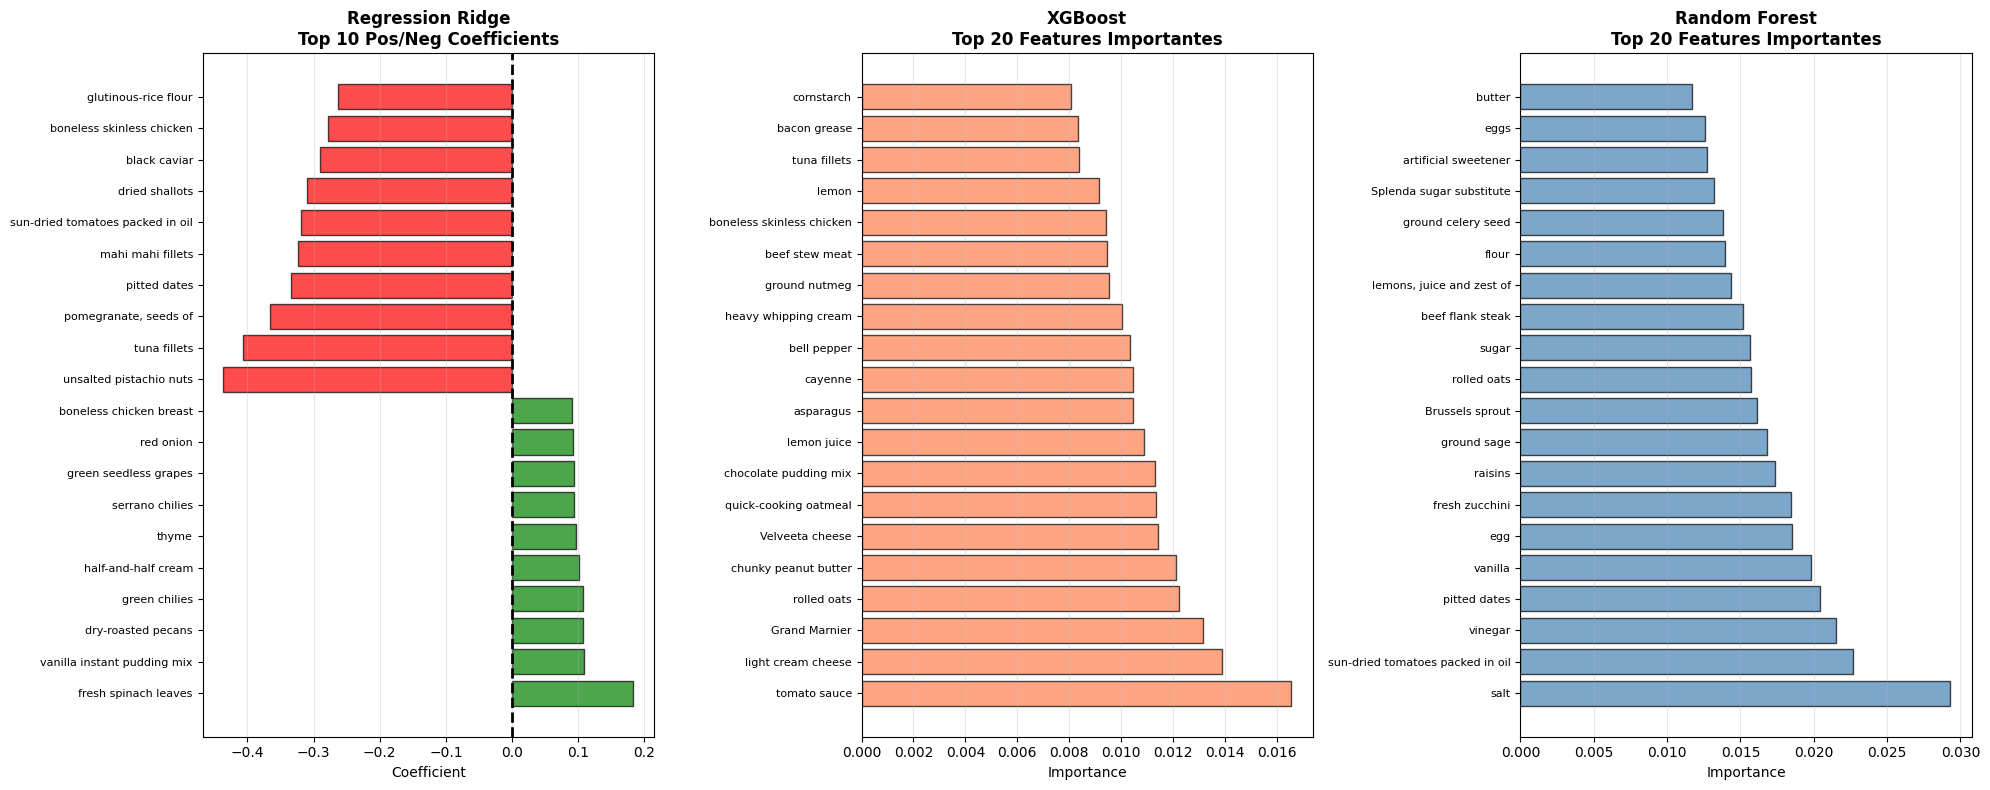

INTERPRETATION :
- Ridge : Coefficients positifs (augmentent note) vs negatifs (diminuent note)
- XGBoost & RF : Importance indique la contribution de chaque feature
- Les modeles peuvent identifier differents ingredients cles


In [104]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Ridge - Top 20 coefficients
ridge_top20 = pd.concat([
    ridge_coef_df.sort_values('Coefficient', ascending=False).head(10),
    ridge_coef_df.sort_values('Coefficient', ascending=True).head(10)
])
colors_ridge = ['green' if c > 0 else 'red' for c in ridge_top20['Coefficient']]
axes[0].barh(range(len(ridge_top20)), ridge_top20['Coefficient'], color=colors_ridge, alpha=0.7, edgecolor='black')
axes[0].set_yticks(range(len(ridge_top20)))
axes[0].set_yticklabels(ridge_top20['Feature'], fontsize=8)
axes[0].set_xlabel('Coefficient', fontsize=10)
axes[0].set_title('Regression Ridge\nTop 10 Pos/Neg Coefficients', fontsize=12, fontweight='bold')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[0].grid(axis='x', alpha=0.3)

# XGBoost - Top 20
xgb_top20 = xgb_importance_df.head(20)
axes[1].barh(range(len(xgb_top20)), xgb_top20['Importance'], color='coral', alpha=0.7, edgecolor='black')
axes[1].set_yticks(range(len(xgb_top20)))
axes[1].set_yticklabels(xgb_top20['Feature'], fontsize=8)
axes[1].set_xlabel('Importance', fontsize=10)
axes[1].set_title('XGBoost\nTop 20 Features Importantes', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Random Forest - Top 20
rf_top20 = rf_importance_df.head(20)
axes[2].barh(range(len(rf_top20)), rf_top20['Importance'], color='steelblue', alpha=0.7, edgecolor='black')
axes[2].set_yticks(range(len(rf_top20)))
axes[2].set_yticklabels(rf_top20['Feature'], fontsize=8)
axes[2].set_xlabel('Importance', fontsize=10)
axes[2].set_title('Random Forest\nTop 20 Features Importantes', fontsize=12, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 80)
print("INTERPRETATION :")
print("- Ridge : Coefficients positifs (augmentent note) vs negatifs (diminuent note)")
print("- XGBoost & RF : Importance indique la contribution de chaque feature")
print("- Les modeles peuvent identifier differents ingredients cles")
print("=" * 80)

### **7. Predictions sur Echantillons de Test**

In [105]:
sample_indices = np.random.choice(X_test.index, size=10, replace=False)
X_sample = X_test.loc[sample_indices]
y_sample = y_test.loc[sample_indices]

pred_ridge = np.clip(linear_model.predict(X_sample), 0, 1)
pred_xgb = np.clip(xgb_model.predict(X_sample), 0, 1)
pred_rf = np.clip(rf_model_bo3.predict(X_sample), 0, 1)

predictions_comparison = pd.DataFrame({
    'Reelle': y_sample.values * 5,
    'Ridge': pred_ridge * 5,
    'XGBoost': pred_xgb * 5,
    'Random Forest': pred_rf * 5,
    'Erreur Ridge': np.abs(y_sample.values - pred_ridge) * 5,
    'Erreur XGBoost': np.abs(y_sample.values - pred_xgb) * 5,
    'Erreur RF': np.abs(y_sample.values - pred_rf) * 5
})

print("=" * 110)
print("COMPARAISON DES PREDICTIONS (10 Recettes de Test Aleatoires) - ETOILES /5")
print("=" * 110)
print(predictions_comparison.to_string(index=False, float_format='%.2f'))
print("=" * 110)
print(f"\nErreurs Moyennes :")
print(f"  Ridge         : {predictions_comparison['Erreur Ridge'].mean():.3f} etoiles")
print(f"  XGBoost       : {predictions_comparison['Erreur XGBoost'].mean():.3f} etoiles")
print(f"  Random Forest : {predictions_comparison['Erreur RF'].mean():.3f} etoiles")
print("=" * 110)

COMPARAISON DES PREDICTIONS (10 Recettes de Test Aleatoires) - ETOILES /5
 Reelle  Ridge  XGBoost  Random Forest  Erreur Ridge  Erreur XGBoost  Erreur RF
   5.00   4.53     4.55           4.55          0.47            0.45       0.45
   3.75   4.52     4.55           4.55          0.77            0.80       0.80
   4.54   4.19     4.55           4.55          0.35            0.01       0.01
   4.38   4.54     4.53           4.55          0.16            0.15       0.18
   4.54   4.51     4.55           4.55          0.03            0.01       0.01
   4.54   4.64     4.55           4.55          0.10            0.01       0.01
   4.38   4.62     4.57           4.55          0.24            0.19       0.18
   5.00   4.72     4.55           4.55          0.28            0.45       0.45
   5.00   4.53     4.55           4.55          0.47            0.45       0.45
   5.00   4.58     4.55           4.55          0.42            0.45       0.45

Erreurs Moyennes :
  Ridge         : 0.330 et

### **8. Comparaison Finale des 3 Modeles**

In [106]:
comparison_results = pd.DataFrame({
    'Modele': ['Ridge', 'XGBoost', 'Random Forest'],
    'R² Train': [r2_train, r2_train_xgb, r2_train_rf],
    'R² Test': [r2_test, r2_test_xgb, r2_test_rf],
    'MAE Test': [mae_test, mae_test_xgb, mae_test_rf],
    'RMSE Test': [rmse_test, rmse_test_xgb, rmse_test_rf],
    'MAE (etoiles/5)': [mae_test * 5, mae_test_xgb * 5, mae_test_rf * 5],
    'RMSE (etoiles/5)': [rmse_test * 5, rmse_test_xgb * 5, rmse_test_rf * 5],
    'Temps (s)': [time_ridge, time_xgb, time_rf]
})

print("\n" + "=" * 110)
print("TABLEAU COMPARATIF - PREDICTION DE NOTES (INGREDIENTS UNIQUEMENT)")
print("=" * 110)
print(comparison_results.to_string(index=False))
print("=" * 110)

best_model_idx = comparison_results['R² Test'].idxmax()
best_model_name = comparison_results.loc[best_model_idx, 'Modele']
best_r2 = comparison_results.loc[best_model_idx, 'R² Test']

print(f"\nMEILLEUR MODELE : {best_model_name}")
print(f"   R² Score : {best_r2:.4f}")
print(f"   MAE : {comparison_results.loc[best_model_idx, 'MAE (etoiles/5)']:.2f} etoiles")
print(f"   RMSE : {comparison_results.loc[best_model_idx, 'RMSE (etoiles/5)']:.2f} etoiles")
print(f"   Temps entrainement : {comparison_results.loc[best_model_idx, 'Temps (s)']:.2f}s")
print("=" * 110)


TABLEAU COMPARATIF - PREDICTION DE NOTES (INGREDIENTS UNIQUEMENT)
       Modele  R² Train   R² Test  MAE Test  RMSE Test  MAE (etoiles/5)  RMSE (etoiles/5)  Temps (s)
        Ridge  0.148637 -0.077432  0.069497   0.114995         0.347483          0.574977   2.876859
      XGBoost  0.121532 -0.010331  0.061645   0.111357         0.308223          0.556785   8.053982
Random Forest  0.057699 -0.003768  0.061436   0.110995         0.307179          0.554973  51.516762

MEILLEUR MODELE : Random Forest
   R² Score : -0.0038
   MAE : 0.31 etoiles
   RMSE : 0.55 etoiles
   Temps entrainement : 51.52s


### **9. Exportation du Modele Random Forest**

In [107]:
import joblib
import json
import os

os.makedirs('models/BO3', exist_ok=True)

print("=" * 80)
print("EXPORTATION DU MODELE RANDOM FOREST (BO3)")
print("=" * 80)

# 1. Sauvegarder le modele Random Forest entraine
joblib.dump(rf_model_bo3, 'models/BO3/random_forest_rating_model.pkl')
print("Modele Random Forest sauvegarde : models/BO3/random_forest_rating_model.pkl")

# 2. Sauvegarder les noms des colonnes d'ingredients
ingredient_cols = X.columns.tolist()
with open('models/BO3/feature_names.json', 'w') as f:
    json.dump(ingredient_cols, f, indent=2)
print(f"Noms des features sauvegardes : models/BO3/feature_names.json ({len(ingredient_cols)} ingredients)")

# 3. Sauvegarder les metadonnees du modele
metadata = {
    "model_type": "Random Forest Regressor",
    "features": "Ingredients uniquement (one-hot encoded avec quantites)",
    "target": "AggregatedRating (normalise 0-1)",
    "n_estimators": 100,
    "max_depth": 15,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    "n_features": len(ingredient_cols),
    "mae_test": float(mae_test_rf),
    "rmse_test": float(rmse_test_rf),
    "r2_test": float(r2_test_rf),
    "trained_on_samples": X_train.shape[0],
    "tested_on_samples": X_test.shape[0],
    "mae_stars": float(mae_test_rf * 5),
    "rmse_stars": float(rmse_test_rf * 5),
    "training_time_seconds": float(time_rf)
}

with open('models/BO3/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("Metadonnees sauvegardees : models/BO3/model_metadata.json")

print("\n" + "=" * 80)
print("EXPORTATION TERMINEE AVEC SUCCES")
print("=" * 80)
print("\nFichiers exportes :")
print("  1. models/BO3/random_forest_rating_model.pkl")
print(f"  2. models/BO3/feature_names.json ({len(ingredient_cols)} ingredients)")
print("  3. models/BO3/model_metadata.json")
print(f"\nPerformance du modele :")
print(f"  - R² Score : {r2_test_rf:.4f}")
print(f"  - MAE : {mae_test_rf * 5:.2f} etoiles (sur 5)")
print(f"  - RMSE : {rmse_test_rf * 5:.2f} etoiles")
print(f"  - Temps entrainement : {time_rf:.2f}s")
print("\nPret pour integration backend FastAPI")
print("=" * 80)

EXPORTATION DU MODELE RANDOM FOREST (BO3)
Modele Random Forest sauvegarde : models/BO3/random_forest_rating_model.pkl
Noms des features sauvegardes : models/BO3/feature_names.json (3618 ingredients)
Metadonnees sauvegardees : models/BO3/model_metadata.json

EXPORTATION TERMINEE AVEC SUCCES

Fichiers exportes :
  1. models/BO3/random_forest_rating_model.pkl
  2. models/BO3/feature_names.json (3618 ingredients)
  3. models/BO3/model_metadata.json

Performance du modele :
  - R² Score : -0.0038
  - MAE : 0.31 etoiles (sur 5)
  - RMSE : 0.55 etoiles
  - Temps entrainement : 51.52s

Pret pour integration backend FastAPI
